In [1]:
import numpy as np
import torch
import os
import net
import utils
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image, make_grid
from time import time
import pickle
import random
from pathlib import Path

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [12]:
BATCH_SIZE = 32
DS_FOLDER = "/home/ML_courses/03683533_2021/dataset"
LR = 1e-4
DEVICE_ID = 1
VAL_RANGE = 1000
TRAIN_RANGE = None
NUM_WORKERS = 16
NUM_EPOCHS = 20
SHUFFLE = False
RUN_NAME = 'baseline_bn_leakyr_mse'

# Network and optimizer

In [13]:
model = net.AutoEncoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
device = f'cuda:{DEVICE_ID}' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

cuda:1


AutoEncoder(
  (activation): LeakyReLU(negative_slope=0.01)
  (last_activation): Sigmoid()
  (enc1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (enc1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc5): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc5_bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_runni

# Data Loader & Dataset

In [14]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.ToTensor(),
                                ])

class UniDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        x = Image.open(image_path)
        if self.transform is not None:
            x = self.transform(x)
        return x
    
    def __len__(self):
        return len(self.image_paths)

In [15]:
val_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[:VAL_RANGE]]
if TRAIN_RANGE != None:
    train_files = [os.path.join(DS_FOLDER,i) for i in 
                   sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:TRAIN_RANGE+1+VAL_RANGE]]
else:
    train_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:]]

In [16]:
val_ds = UniDataset(val_files, transform=transform)
train_ds = UniDataset(train_files, transform=transform)

In [17]:
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True, shuffle=SHUFFLE)

# Train model

In [18]:
def save_imgs(true_imgs, val_imgs, dirname, epoch):
    path = os.path.join('results', RUN_NAME, epoch)
    os.makedirs(path, exist_ok=True)
    save_image(val_imgs, os.path.join(path, 'val_pred.png'))
    save_image(true_imgs, os.path.join(path, 'val_true.png'))

In [19]:
def calc_val_loss(val_dl, epoch, dirname):
    with torch.no_grad():
        val_loss = 0.0
        for images in val_dl:
            images = images.float().to(device)
            outputs = model(images)
            images.require_grad = False
            loss = criterion(outputs, images)
            val_loss += loss.item()
    images = images.cpu()
    outputs = outputs.view(outputs.size(0), 3, 256, 256).cpu().data
    save_imgs(images, outputs, dirname, epoch)
    return val_loss/len(val_dl), make_grid(images), make_grid(outputs)

In [20]:
%%time

train_losses = {}
val_losses = {}
for epoch in range(1, NUM_EPOCHS+1):
    t = time()
    train_loss = 0.0
    for images in tqdm(train_dl):
        images = images.float()
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    val_loss, val_true_grid, val_pred_grid = calc_val_loss(val_dl, str(epoch), RUN_NAME)
    train_loss = train_loss/len(train_dl)
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    print('Epoch: {} \tTraining Loss: {:.6f} \tVal Loss: {:.6f}\t \
    in time {:2f}m'.format(epoch, train_loss, val_loss, (time()-t)/60))


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:14<00:00,  9.05it/s]


Epoch: 1 	Training Loss: 0.028311 	Val Loss: 0.017146	     in time 2.288076m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:18<00:00,  8.78it/s]


Epoch: 2 	Training Loss: 0.014172 	Val Loss: 0.011668	     in time 2.357501m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:19<00:00,  8.71it/s]


Epoch: 3 	Training Loss: 0.010340 	Val Loss: 0.008972	     in time 2.374994m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:20<00:00,  8.69it/s]


Epoch: 4 	Training Loss: 0.008281 	Val Loss: 0.007497	     in time 2.382553m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:19<00:00,  8.75it/s]


Epoch: 5 	Training Loss: 0.007104 	Val Loss: 0.006664	     in time 2.365217m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:18<00:00,  8.80it/s]


Epoch: 6 	Training Loss: 0.006466 	Val Loss: 0.006233	     in time 2.351951m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:19<00:00,  8.71it/s]


Epoch: 7 	Training Loss: 0.006114 	Val Loss: 0.005935	     in time 2.377044m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:19<00:00,  8.76it/s]


Epoch: 8 	Training Loss: 0.005868 	Val Loss: 0.005732	     in time 2.363969m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:19<00:00,  8.73it/s]


Epoch: 9 	Training Loss: 0.005674 	Val Loss: 0.005552	     in time 2.371717m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:20<00:00,  8.68it/s]


Epoch: 10 	Training Loss: 0.005499 	Val Loss: 0.005397	     in time 2.385099m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:20<00:00,  8.65it/s]


Epoch: 11 	Training Loss: 0.005352 	Val Loss: 0.005249	     in time 2.394080m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:21<00:00,  8.64it/s]


Epoch: 12 	Training Loss: 0.005214 	Val Loss: 0.005133	     in time 2.394930m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:20<00:00,  8.68it/s]


Epoch: 13 	Training Loss: 0.005109 	Val Loss: 0.005046	     in time 2.385826m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:20<00:00,  8.70it/s]


Epoch: 14 	Training Loss: 0.005025 	Val Loss: 0.004962	     in time 2.377798m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:20<00:00,  8.68it/s]


Epoch: 15 	Training Loss: 0.004947 	Val Loss: 0.004886	     in time 2.386043m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:19<00:00,  8.72it/s]


Epoch: 16 	Training Loss: 0.004880 	Val Loss: 0.004831	     in time 2.374850m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:20<00:00,  8.67it/s]


Epoch: 17 	Training Loss: 0.004829 	Val Loss: 0.004788	     in time 2.388710m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:21<00:00,  8.63it/s]


Epoch: 18 	Training Loss: 0.004782 	Val Loss: 0.004743	     in time 2.394863m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:20<00:00,  8.65it/s]


Epoch: 19 	Training Loss: 0.004739 	Val Loss: 0.004702	     in time 2.392891m


100%|██████████████████████████████████████████████████████████████████████████████████| 1219/1219 [02:21<00:00,  8.63it/s]


Epoch: 20 	Training Loss: 0.004699 	Val Loss: 0.004672	     in time 2.395297m
CPU times: user 37min 51s, sys: 12min 24s, total: 50min 15s
Wall time: 47min 30s


# Results

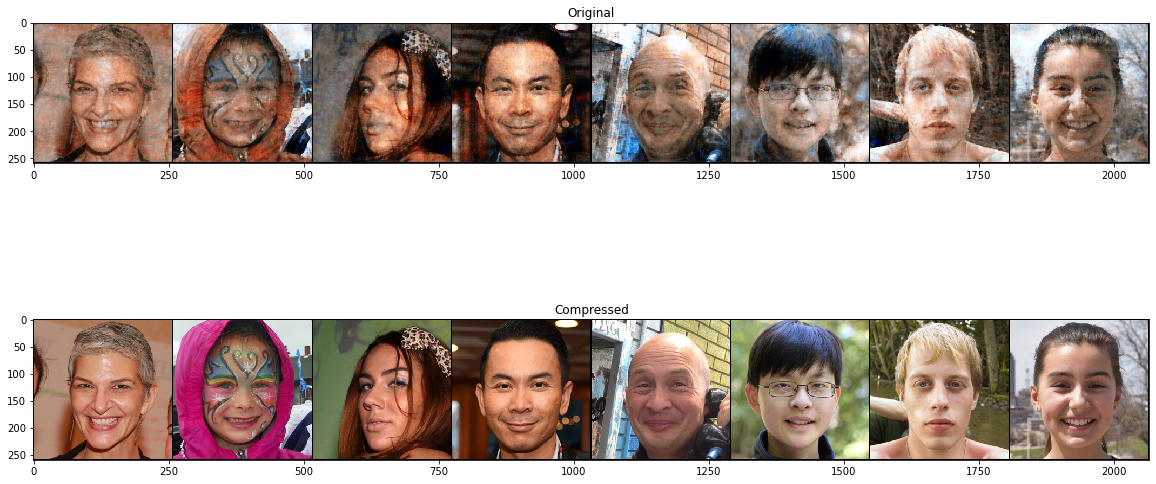

In [21]:
utils.show(val_true_grid, val_pred_grid)

In [22]:
path = Path("results") / RUN_NAME

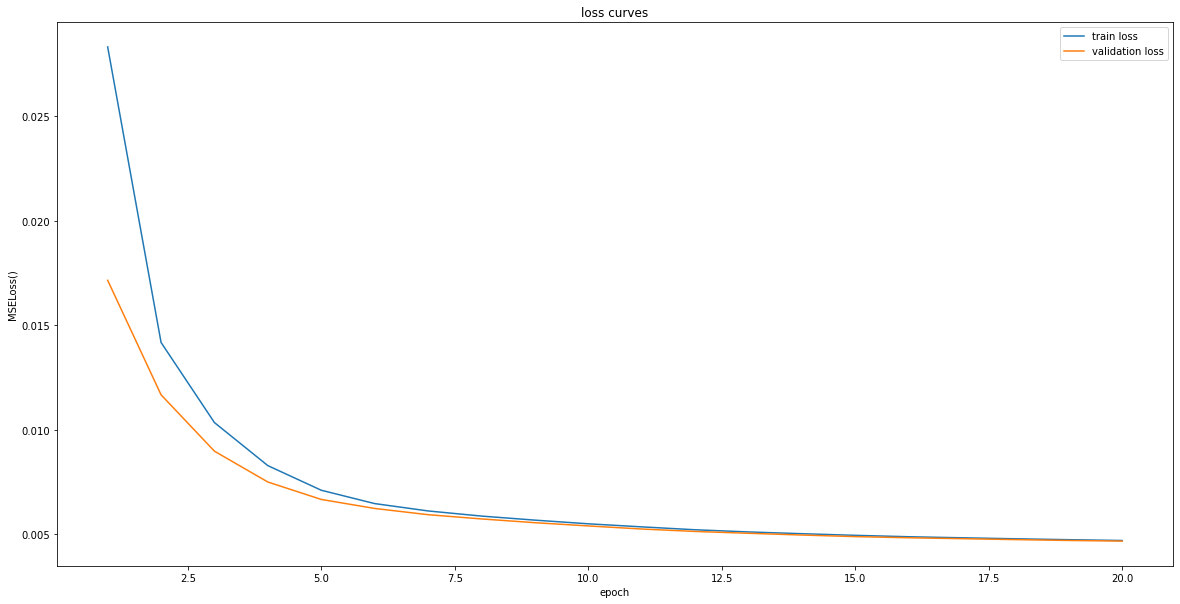

In [23]:
utils.plot_loss(criterion, train_losses, val_losses, path)

In [24]:
utils.write_losses(path, train_losses, val_losses)

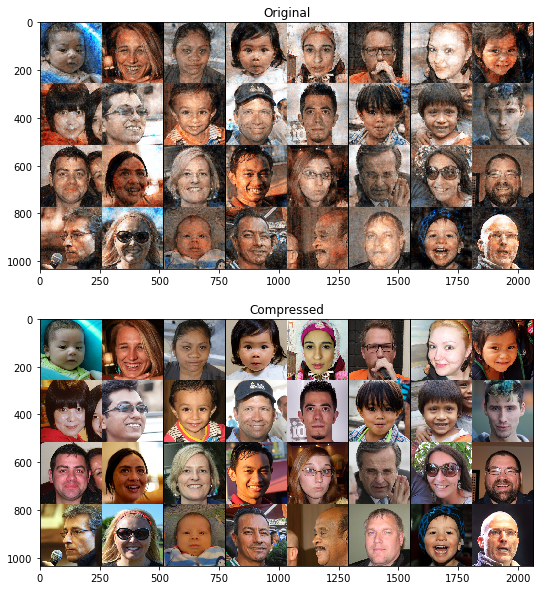

In [25]:
images = list(val_dl)[0]
outputs = model(images.to(device)).cpu()
utils.show(make_grid(images), make_grid(outputs), save=True, path=path)